In [1]:
import chess
import chess.pgn
import glob
import numpy as np
import utils

In [2]:
from stockfish import Stockfish
stockfish = Stockfish(path="./stockfish-ubuntu-x86-64-avx2")

path = 'data/5_less.pgn'

num_games = 0
endplay_games = 0

inputs = []
outputs = []

for filepath in glob.glob(path):
    with open(filepath, encoding="utf-8", errors="ignore") as file:
        while(True):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            num_games += 1
            if (num_games % 500) == 0:
                print(num_games)
            final_board = game.end().board()
            num_pieces = len(final_board.piece_map())
            if (game.headers["Result"] == "1-0"): # just look at white wins for now, as convention
                end_node = game.end()
                node = end_node
                for _ in range(5): # go back 5 plies
                    node = node.parent
                if node.board().turn == chess.WHITE:
                    node = node.parent
                stockfish.set_fen_position(node.board().fen())
                evaluation = stockfish.get_evaluation()
                if ((evaluation['type'] == 'cp') and (evaluation['value']) > 300) or ((evaluation['type'] == "mate") and (evaluation['value'] > 0)): # white is winning
                    x = utils.board_to_tensor(node.board())
                    y = utils.move_to_tensor(node.variations[0].move)
                    inputs.append(x)
                    outputs.append(y)
                    endplay_games += 1

print(num_games, endplay_games)

500


no matching legal move for e2e4 (e2 -> e4) in 6k1/4P3/r3R3/4K3/8/8/8/8 b - - 10 64 while parsing <Game at 0x7c4270249000 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'f1' in 8/8/8/8/5b2/8/4Kpk1/5N2 w - - 3 77 while parsing <Game at 0x7c4270188f70 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'ga1' in 8/8/1P6/3k3p/8/4B3/7K/8 w - - 5 63 while parsing <Game at 0x7c42700de0b0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'g1' in 8/8/8/p5P1/1Rk4K/8/8/8 b - - 0 62 while parsing <Game at 0x7c4273d692a0 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/3K4/5P1p/7k/8/3B4/8/8 b - - 0 66 while parsing <Game at 0x7c427014c610 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'h2' in 8/7K/4k3/6P1/6r1/8/8/8 w - - 0 85 while parsing <Game at 0x7c4270143010 ('?' vs. '?', '????.??.??' at '?')>


1000


no matching legal move for e2e4 (e2 -> e4) in 8/K2k4/1P6/8/8/8/8/8 b - - 2 60 while parsing <Game at 0x7c42701427d0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'g1' in 8/6p1/8/5k1p/7P/6K1/8/8 w - - 0 57 while parsing <Game at 0x7c4273d58b20 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'g1' in 8/2k5/4K3/1pP5/4B3/8/8/8 b - - 0 60 while parsing <Game at 0x7c42701b7af0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'ch5' in 8/8/8/8/8/5pk1/6N1/1r4K1 w - - 4 53 while parsing <Game at 0x7c4270695030 ('?' vs. '?', '????.??.??' at '?')>


1500
2000


illegal san: 'Be1' in 5k2/3b4/5K2/8/8/8/1R6/8 b - - 2 73 while parsing <Game at 0x7c42700dd060 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'a1' in 8/8/8/8/8/2n1K3/4N1p1/7k w - - 12 93 while parsing <Game at 0x7c4273d80cd0 ('?' vs. '?', '????.??.??' at '?')>


2500


illegal san: 'h2' in 8/r3Q2k/5P2/4K3/8/8/8/8 b - - 2 89 while parsing <Game at 0x7c4273e0a980 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/8/8/3r4/8/4R3/2K1pk2/8 w - - 8 106 while parsing <Game at 0x7c4270713130 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/8/8/8/8/3Kp1k1/2n5/8 w - - 2 69 while parsing <Game at 0x7c4270188e80 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/8/4K3/8/4k1p1/8/7p/5R2 w - - 2 57 while parsing <Game at 0x7c42703e7880 ('?' vs. '?', '????.??.??' at '?')>


3000


illegal san: 'a2' in 7R/8/8/8/8/5BK1/8/r4k2 b - - 96 130 while parsing <Game at 0x7c42706d2830 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/6P1/p2k3K/8/8/8/8/2q5 w - - 0 54 while parsing <Game at 0x7c4270054610 ('?' vs. '?', '????.??.??' at '?')>


3500


illegal san: 'e1' in r7/3RK1P1/2k5/8/8/8/8/8 b - - 2 80 while parsing <Game at 0x7c42700592a0 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/2P5/4q3/K7/4k3/8/8/4Q3 b - - 24 86 while parsing <Game at 0x7c42706951b0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'ba2' in 8/8/8/8/kr6/4K3/p7/3R4 w - - 2 65 while parsing <Game at 0x7c4273d82920 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'f1' in 4k3/5p2/2K2P2/4P3/8/8/8/8 b - - 2 78 while parsing <Game at 0x7c42702dea40 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/3k2P1/5K2/5R2/r7/8/8/8 b - - 0 75 while parsing <Game at 0x7c42700f7070 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 5R2/8/8/4r3/8/3K2k1/6p1/8 w - - 8 73 while parsing <Game at 0x7c4270712170 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 7k/8/4R1KP/8/8/8/8/8 b - - 0 99 while parsing <Game at 0x7c42700fe380 ('?' vs. '?', '????.??

4000


illegal san: 'a1' in 5R2/8/8/6K1/1r6/4k3/4p3/8 w - - 2 59 while parsing <Game at 0x7c42700fdd20 ('?' vs. '?', '????.??.??' at '?')>


4500


no matching legal move for e2e4 (e2 -> e4) in 8/P3k3/1K6/1R6/8/8/8/r7 b - - 2 98 while parsing <Game at 0x7c42701cc3d0 ('?' vs. '?', '????.??.??' at '?')>


5000


illegal san: 'Ba1' in 8/8/8/6r1/8/3bk3/8/2R1K3 w - - 14 101 while parsing <Game at 0x7c42706d2ad0 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/8/8/8/8/5bkn/8/7K w - - 90 99 while parsing <Game at 0x7c4270089d20 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'a2' in 8/6K1/8/4k3/7P/8/8/8 b - - 0 77 while parsing <Game at 0x7c4273db6d10 ('?' vs. '?', '????.??.??' at '?')>


5500


no matching legal move for e2e4 (e2 -> e4) in 8/8/R7/kPK5/8/8/8/5b2 b - - 0 89 while parsing <Game at 0x7c42700f74c0 ('?' vs. '?', '????.??.??' at '?')>


6000


illegal san: 'ha1' in 8/1p6/1P6/8/5K2/8/5k2/8 b - - 0 62 while parsing <Game at 0x7c426bf2c550 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'e1' in 8/8/R7/5r2/8/8/3p2K1/3k4 w - - 4 62 while parsing <Game at 0x7c4273e12110 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/8/PN2k3/1K6/8/8/8/6b1 b - - 3 89 while parsing <Game at 0x7c4273e0b9a0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'a1' in 5r2/4R3/2k5/4K3/5P2/8/8/8 b - - 12 66 while parsing <Game at 0x7c4273de4c40 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 1K6/1P6/8/1k6/8/8/R7/6r1 b - - 4 77 while parsing <Game at 0x7c4270001a20 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 4B3/8/8/6r1/8/4kp2/8/5K2 w - - 0 78 while parsing <Game at 0x7c4270016a10 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'ha1' in 8/6K1/2k5/6p1/6P1/8/8/8 b - - 1 66 while parsing <Game at 0x7c42700d6d70 ('?' vs. '?', '????.??.??' at '?')>
illegal

6500
7000


illegal san: 'ha1' in 8/8/8/6p1/8/6k1/8/7K w - - 0 75 while parsing <Game at 0x7c426bf2d090 ('?' vs. '?', '????.??.??' at '?')>


7500


no matching legal move for e2e4 (e2 -> e4) in 2K5/1P6/2q5/8/8/8/6k1/8 w - - 10 92 while parsing <Game at 0x7c4270697a90 ('?' vs. '?', '????.??.??' at '?')>


8000


no matching legal move for e2e4 (e2 -> e4) in 8/P1K1k3/1R6/6r1/8/8/8/8 b - - 0 71 while parsing <Game at 0x7c42701b1bd0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'e1' in 8/2k1K3/1p6/1P6/2P5/8/8/8 b - - 0 58 while parsing <Game at 0x7c42700a6ec0 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/8/7b/8/8/1k6/p1NK4/8 w - - 2 90 while parsing <Game at 0x7c426bf8eb60 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/P2k4/K5R1/8/8/1r6/8/8 b - - 2 61 while parsing <Game at 0x7c427003e170 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/8/8/8/8/2n5/1bk5/K7 w - - 35 106 while parsing <Game at 0x7c4270249b70 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/8/K7/8/7p/6n1/6k1/6B1 w - - 1 72 while parsing <Game at 0x7c42700db760 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 8/5k2/7P/p4K2/P7/8/8/8 b - - 2 91 while parsing

8500
9000


illegal san: 'a1' in 2R5/8/8/8/8/2K2r2/2p5/2k5 w - - 4 57 while parsing <Game at 0x7c4273dc3040 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'e1' in 8/8/8/5K1k/7p/5p1P/8/8 w - - 0 68 while parsing <Game at 0x7c4270106200 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'h2' in 8/1k4P1/5K2/8/5R2/8/8/6r1 b - - 4 66 while parsing <Game at 0x7c4273db6e60 ('?' vs. '?', '????.??.??' at '?')>


9500


illegal san: 'Be1' in Q7/8/8/4p3/8/4K3/8/6k1 b - - 1 78 while parsing <Game at 0x7c4273da1720 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ba1' in 8/7r/1R6/8/8/5K2/6p1/6k1 b - - 3 74 while parsing <Game at 0x7c427012c730 ('?' vs. '?', '????.??.??' at '?')>


10000


no matching legal move for e2e4 (e2 -> e4) in 4R3/8/8/4r3/4k3/8/4p2K/8 w - - 16 102 while parsing <Game at 0x7c4273dc7700 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'e1' in 8/7p/8/1N6/4K3/8/pk6/8 w - - 4 69 while parsing <Game at 0x7c42701a4490 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'a1' in 2R5/1K6/8/8/4p3/5k2/8/5q2 w - - 0 54 while parsing <Game at 0x7c426bfc64d0 ('?' vs. '?', '????.??.??' at '?')>


10500
11000


illegal san: 'a1' in 8/8/1b6/8/8/4k1pp/8/7K w - - 0 70 while parsing <Game at 0x7c42706d2b60 ('?' vs. '?', '????.??.??' at '?')>


11500


illegal san: 'a1' in 8/8/8/3k4/3r2P1/4RK2/8/8 b - - 0 53 while parsing <Game at 0x7c42702bdae0 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in R7/5k1P/8/8/5K2/8/8/6r1 b - - 2 65 while parsing <Game at 0x7c426bf0bc40 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'e1' in 8/8/8/6pN/1K1k2B1/8/8/8 b - - 5 92 while parsing <Game at 0x7c42701f70a0 ('?' vs. '?', '????.??.??' at '?')>


12000


illegal san: 'a1' in 8/8/8/n2B4/5k2/2K5/6P1/8 b - - 5 59 while parsing <Game at 0x7c42700fbca0 ('?' vs. '?', '????.??.??' at '?')>
no matching legal move for e2e4 (e2 -> e4) in 5k2/5N1P/6K1/8/8/8/8/8 b - - 0 113 while parsing <Game at 0x7c4270035120 ('?' vs. '?', '????.??.??' at '?')>


12500


illegal san: 'ha1' in 8/2K5/P3R3/6k1/8/8/r7/8 b - - 6 68 while parsing <Game at 0x7c426bf73df0 ('?' vs. '?', '????.??.??' at '?')>


12904 6095


In [3]:
X = np.stack(inputs)
Y = np.stack(outputs)

np.savez_compressed("data/5_less_tensor.npz", inputs=X, outputs=Y)

Loading NPZ to verify. Rebuild the original board and move

In [4]:
data = np.load("data/5_less_tensor.npz")
X = data['inputs']
Y = data['outputs']

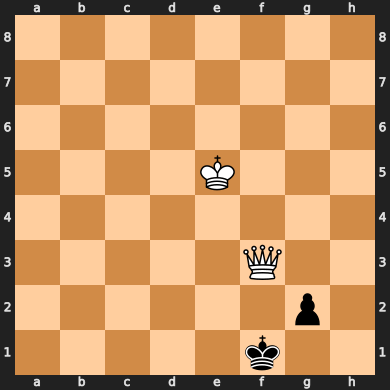

f1g1


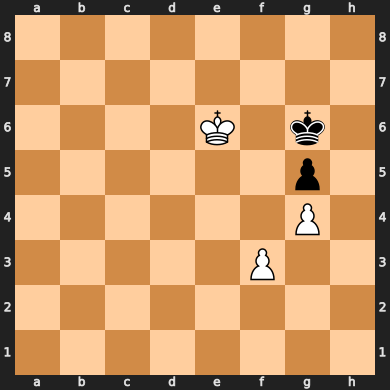

g6g7


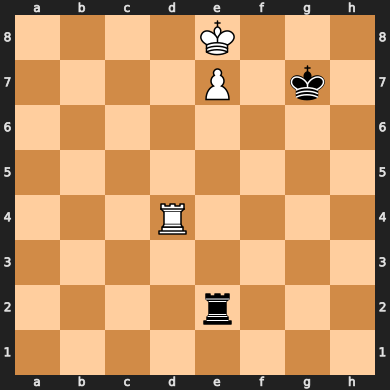

e2e1


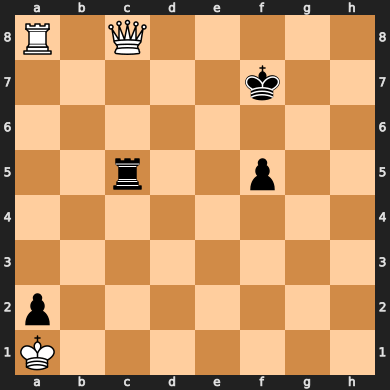

c5c8


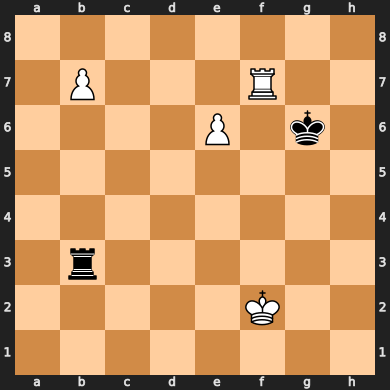

b3b2


In [5]:
for idx in range(5):
    x = X[idx]
    y = Y[idx]
    board = utils.tensor_to_board(x)
    move = utils.tensor_to_move(y)
    display(board)
    print(move)